# Multimodal integration and filtering of HELA spheroid data

## Load packages

In [1]:
# Load packages
import scanpy as sc
import muon as mu
import matplotlib as mpl
import matplotlib.colors as mcolors
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
import phate

mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica"

sc.settings.verbosity = 3 

In [2]:
# Plot settings
# Setup the global plotting parameters
sc.logging.print_header()
sc.set_figure_params(dpi=100, color_map = 'viridis', frameon=True, transparent=True,
                    dpi_save=800, facecolor='None', format='pdf', figsize=[5,5])

# Set seed
np.random.seed(0)

# Figure output directory
sc.settings.figdir = 'mm_preprocessing_figures'

# Colour map
colour_dict = {'Control': 'tab:blue', 
               'EGF IGF1': 'tab:green', 
               'GFs MEKi PI3Ki': 'tab:red'}

scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.10.4 pynndescent==0.5.11


## Load anndata objects and merge with muon

In [3]:
# FP for prepped SIGNAL-seq data
input_file_rna = '../../../F1_hela_code/00_preprocessing_rna/pipe_outputs/ex0003_hela/filtered/h5ad_objects/ex0003_hela_sce_filtered.h5ad' 
input_file_adt = '../../../F1_hela_code/01_preprocessing_adt/ex0003_adt_merged_scanpy.h5ad' 

# h5ad file exported from preprocessing pipeline
adata_mrna = sc.read_h5ad(input_file_rna, backed=False)
adata_adt = sc.read_h5ad(input_file_adt, backed=False)

# Check data shape
adata_mrna

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2753 × 40243
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads'
    var: 'gene_ids'
    uns: 'X_name', 'library_info', 'library_stats', 'seq_run_info'
    layers: 'reads'

In [4]:
del adata_mrna.layers["reads"]

In [5]:
# Load the lnc-RNA gene database
lnc_id_df = pd.read_csv("data/lncipedia_5_2_ensembl_92_genes.txt", sep='\t')

# Extract the gene name mapping
gene_names_df = pd.DataFrame(adata_mrna.var['gene_ids'])
gene_names_df['gene_names'] = gene_names_df.index

# Join the two series
lnc_merged_df = gene_names_df.set_index('gene_ids').join(lnc_id_df.set_index('ensemblGeneID'))

# Create a val of is lnc with TRUE/FALSE
lnc_merged_df['lnc'] = lnc_merged_df['lncipediaGeneID'].notna()

# Convert gene_names vals
lnc_merged_df.lncipediaGeneID.fillna(lnc_merged_df.gene_names, inplace=True)

lnc_merged_df = lnc_merged_df.set_index('gene_names')

# Map to scanpy oject 
# Add new var columns 
adata_mrna.var['lnc'] = lnc_merged_df.lnc
adata_mrna.var['lncipediaGeneID'] = lnc_merged_df.lncipediaGeneID	

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_53204/3470009073.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lnc_merged_df.lncipediaGeneID.fillna(lnc_merged_df.gene_names, inplace=True)


In [6]:
# Calculate cell specific metrics
adata_mrna.var_names_make_unique()

# Label MT genes
adata_mrna.var['mt'] = adata_mrna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

# Generate per cell QC metrics for the annotated genes
sc.pp.calculate_qc_metrics(adata_mrna, qc_vars=['mt', 'lnc'], percent_top=None, log1p=False, inplace=True)

# Convert barcode plate index to seq
adata_mrna.obs.index = adata_mrna.obs.barcode_seq

print(adata_mrna, ": data shape:", adata_mrna.shape)

AnnData object with n_obs × n_vars = 2753 × 40243
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_lnc', 'pct_counts_lnc'
    var: 'gene_ids', 'lnc', 'lncipediaGeneID', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'X_name', 'library_info', 'library_stats', 'seq_run_info' : data shape: (2753, 40243)


In [7]:
# Filtering possible doublet outliers based on IQR of total counts
# Define the outlier cutoffs
# UMI IQR deviation by log10 value
umi_total_log = np.log10(adata_mrna.obs.total_counts)
umi_med = umi_total_log.median()
umi_med

# Include new param for log10 counts
adata_mrna.obs['log10_total_counts'] = umi_total_log

# Computing IQR
Q1 = umi_total_log.quantile(0.25)
Q3 = umi_total_log.quantile(0.75)
IQR = Q3 - Q1
IQR

# Initilise the UMI Cutoff for 2*IQR past the med of Log10
umi_cutoff = umi_med + (2 * IQR)
umi_cutoff

4.773516639447294

In [8]:
# Compute UMI/Reads ratio
adata_mrna.obs['umi_rds_ratio'] = adata_mrna.obs['total_counts'] / adata_mrna.obs['mapped_reads']

In [9]:
# Define outliers and filter
adata_mrna.obs['outlier_total'] = adata_mrna.obs.log10_total_counts > umi_cutoff
adata_mrna.obs['outlier_ngenes'] = adata_mrna.obs.n_genes_by_counts > 12000
adata_mrna.obs['lowq_counts'] = adata_mrna.obs.total_counts < 500
adata_mrna.obs['lowq_mt'] = adata_mrna.obs.pct_counts_mt > 30
adata_mrna.obs['outlier_rds'] = adata_mrna.obs.umi_rds_ratio > 0.75


print('%u cells with large total counts' % (sum(adata_mrna.obs['outlier_total'])))
print('%u cells with large number of genes' % (sum(adata_mrna.obs['outlier_ngenes'])))
print('%u cells with low total counts' % (sum(adata_mrna.obs['lowq_counts'])))
print('%u cells with high mitochondrial counts' % (sum(adata_mrna.obs['lowq_mt'])))
print('%u cells with high reads ratio' % (sum(adata_mrna.obs['outlier_rds'])))


adata_mrna = adata_mrna[~adata_mrna.obs['outlier_total'], :]
adata_mrna = adata_mrna[~adata_mrna.obs['outlier_ngenes'], :]
adata_mrna = adata_mrna[~adata_mrna.obs['lowq_counts'], :]
adata_mrna = adata_mrna[~adata_mrna.obs['lowq_mt'], :]
adata_mrna = adata_mrna[~adata_mrna.obs['outlier_rds'], :]

# Filter out lowly expressed genes and cells with low complexity
sc.pp.filter_genes(adata_mrna, min_cells=3)
sc.pp.filter_cells(adata_mrna, min_genes=100)

29 cells with large total counts
4 cells with large number of genes
0 cells with low total counts
132 cells with high mitochondrial counts
13 cells with high reads ratio
filtered out 10301 genes that are detected in less than 3 cells


filtered out 393 cells that have less than 100 genes expressed


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [10]:
# Examine RNA ad object
print(adata_mrna, ": data shape:", adata_mrna.shape)

AnnData object with n_obs × n_vars = 2186 × 29942
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_lnc', 'pct_counts_lnc', 'log10_total_counts', 'umi_rds_ratio', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes'
    var: 'gene_ids', 'lnc', 'lncipediaGeneID', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'X_name', 'library_info', 'library_stats', 'seq_run_info' : data shape: (2186, 29942)


## Map unfiltered ADT data with mRNA data by barcode seq

In [11]:
# Examine the ADT ad object
print(adata_adt, ": data shape:", adata_adt.shape)

AnnData object with n_obs × n_vars = 91441 × 23
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3'
    var: 'feature_name', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts' : data shape: (91441, 23)


In [12]:
# Extract the barcodes from the mRNA dataset
mrna_barcodes = adata_mrna.obs.index

mrna_barcodes

# Map the mrna barcodes onto the ADT data
prot_adata = adata_adt[adata_adt.obs_names.isin(mrna_barcodes)]
prot_adata

View of AnnData object with n_obs × n_vars = 2155 × 23
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3'
    var: 'feature_name', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [13]:
# Extract the barcodes from the mRNA dataset
adt_barcodes = prot_adata.obs.index

# Map the mrna barcodes onto the ADT data
adata_mrna = adata_mrna[adata_mrna.obs_names.isin(adt_barcodes)]
adata_mrna

View of AnnData object with n_obs × n_vars = 2155 × 29942
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_lnc', 'pct_counts_lnc', 'log10_total_counts', 'umi_rds_ratio', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes'
    var: 'gene_ids', 'lnc', 'lncipediaGeneID', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'X_name', 'library_info', 'library_stats', 'seq_run_info'

## Protein ADT adata filtering

In [14]:
# Filter the protein data
# define outliers and filter for the dataset
prot_adata.obs['outlier_nantigens'] = prot_adata.obs.n_genes_by_counts < 11
prot_adata.obs['outlier_adt_counts'] = prot_adata.obs.total_counts < 40


print('%u cells with low number of Antigens' % (sum(prot_adata.obs['outlier_nantigens'])))
print('%u cells with low number of ADT counts' % (sum(prot_adata.obs['outlier_adt_counts'])))


prot_adata = prot_adata[~prot_adata.obs['outlier_nantigens'], :]
prot_adata = prot_adata[~prot_adata.obs['outlier_adt_counts'], :]

956 cells with low number of Antigens
791 cells with low number of ADT counts


/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_53204/2257855796.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  prot_adata.obs['outlier_nantigens'] = prot_adata.obs.n_genes_by_counts < 11


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


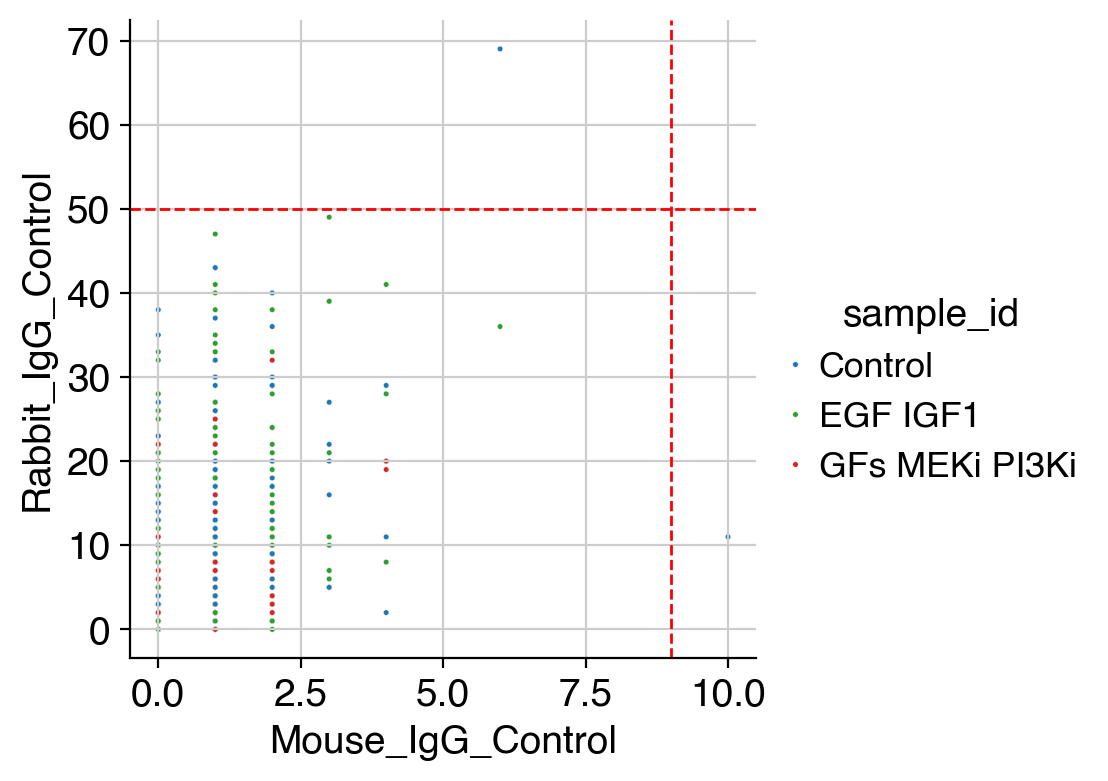

In [15]:
protein_markers = prot_adata.var_names
protein_data = sc.get.obs_df(
    prot_adata,
    keys=['sample_id' , *protein_markers]
)
sns.pairplot(data=protein_data, x_vars="Mouse_IgG_Control", y_vars="Rabbit_IgG_Control", size = 4,
                 plot_kws={"s": 4}, palette=colour_dict, hue='sample_id')

plt.axvline(x=9, ls='--', linewidth=1, color='red')
plt.axhline(y=50, ls='--', linewidth=1, color='red')
                 
plt.savefig('mm_preprocessing_figures/mouse_v_rabbit_IgG_control_adt_counts.pdf', dpi=800)

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


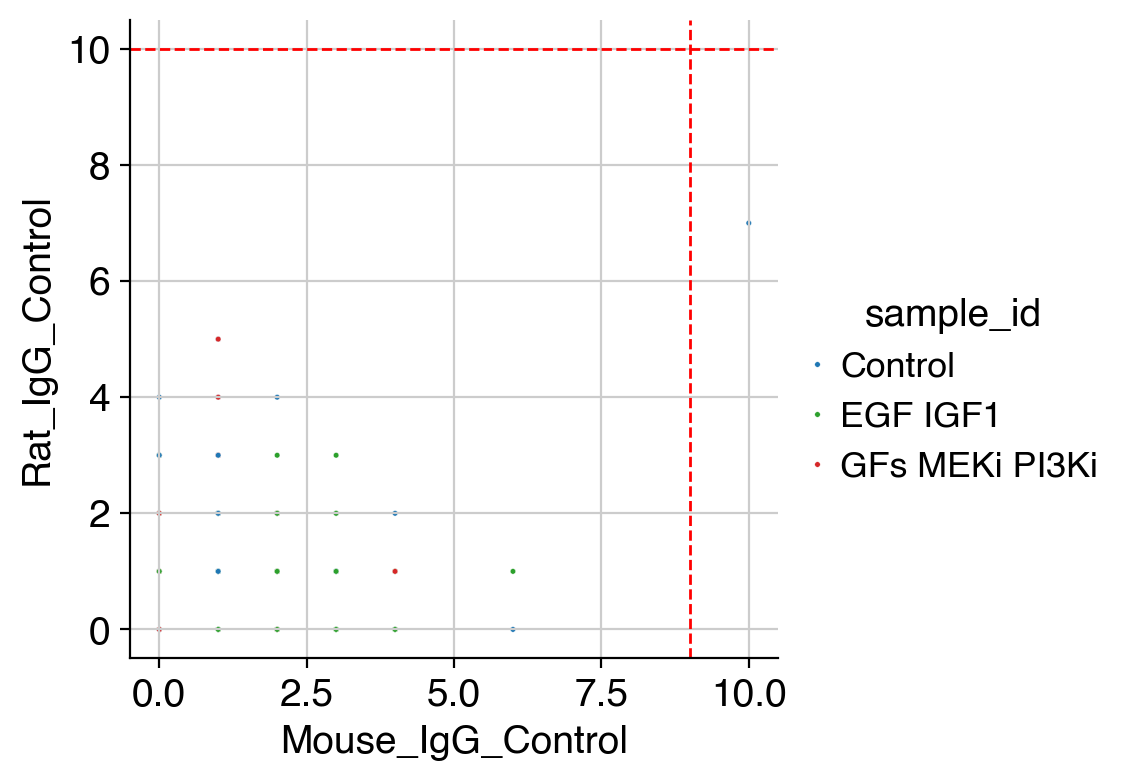

In [16]:
sns.pairplot(data=protein_data, x_vars="Mouse_IgG_Control", y_vars="Rat_IgG_Control", size = 4,
              plot_kws={"s": 4}, palette=colour_dict, hue='sample_id')

plt.axvline(x=9, ls='--', linewidth=1, color='red')
plt.axhline(y=10, ls='--', linewidth=1, color='red')
                 
plt.savefig('mm_preprocessing_figures/rat_vs_mouse_control_adt_counts.pdf', dpi=800)

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


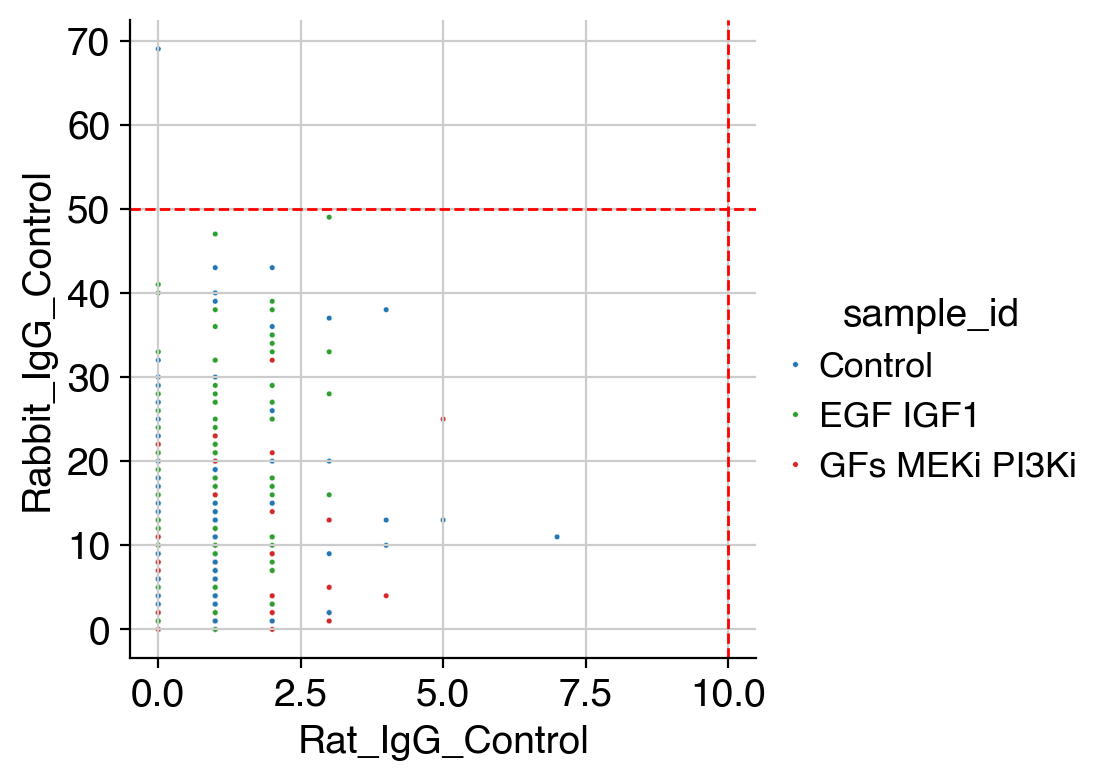

In [17]:
sns.pairplot(data=protein_data, x_vars="Rat_IgG_Control", y_vars="Rabbit_IgG_Control", size = 4,
              plot_kws={"s": 4}, palette=colour_dict, hue='sample_id')

plt.axvline(x=10, ls='--', linewidth=1, color='red')
plt.axhline(y=50, ls='--', linewidth=1, color='red')

plt.savefig('mm_preprocessing_figures/GFP_IgG_adt_counts.pdf', dpi=800)

In [18]:
# Filter based on the control antibodies
prot_adata = prot_adata[prot_adata[: , 'Mouse_IgG_Control'].X < 9, :]
prot_adata = prot_adata[prot_adata[: , 'Rat_IgG_Control'].X < 10, :]
prot_adata = prot_adata[prot_adata[: , 'Rabbit_IgG_Control'].X < 50, :]

prot_adata

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_53204/2640505342.py:2: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  prot_adata = prot_adata[prot_adata[: , 'Mouse_IgG_Control'].X < 9, :]
/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_53204/2640505342.py:3: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  prot_adata = prot_adata[prot_adata[: , 'Rat_IgG_Control'].X < 10, :]
/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_53204/2640505342.py:4: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  prot_adata = prot_adata[prot_adata[: , 'Rabbit_IgG_Control'].X < 50, :]


View of AnnData object with n_obs × n_vars = 1143 × 23
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3', 'outlier_nantigens', 'outlier_adt_counts'
    var: 'feature_name', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [19]:
# Filter the RNA data
# Extract the barcodes from the RNA dataset
prot_barcodes = prot_adata.obs.index

# Map the RNA barcodes onto the ADT data
adata_mrna_filtered = adata_mrna[adata_mrna.obs_names.isin(prot_barcodes)]

# Filter out lowly expressed genes 
sc.pp.filter_genes(adata_mrna_filtered, min_cells=3)

adata_mrna_filtered

filtered out 705 genes that are detected in less than 3 cells


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


AnnData object with n_obs × n_vars = 1143 × 29237
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_lnc', 'pct_counts_lnc', 'log10_total_counts', 'umi_rds_ratio', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes'
    var: 'gene_ids', 'lnc', 'lncipediaGeneID', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'X_name', 'library_info', 'library_stats', 'seq_run_info'

In [20]:
mdata = mu.MuData({'rna': adata_mrna_filtered, 'protein': prot_adata})
mdata

MuData object with n_obs × n_vars = 1143 × 29260
  var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	1143 x 29237
      obs:	'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_lnc', 'pct_counts_lnc', 'log10_total_counts', 'umi_rds_ratio', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes'
      var:	'gene_ids', 'lnc', 'lncipediaGeneID', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'X_name', 'library_info', 'library_stats', 'seq_run_info'
    protein:	1143 x 23
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3', 'outlier_nantigens', 'outlier_adt_counts'
      var:	'feature_name', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [21]:
# Set counts layer
adata_mrna_filtered.layers["counts"] = adata_mrna_filtered.X.copy()

# Count based normalization
sc.pp.normalize_total(adata_mrna_filtered, target_sum=1e4, exclude_highly_expressed=True, max_fraction=0.05) # Total count normalization to 10000 umi per cell

# Log data
sc.pp.log1p(adata_mrna_filtered)

# Extract raw log-norm data for future tests
adata_mrna_filtered.raw = adata_mrna_filtered

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['HFM1', 'MT-RNR2', 'MT-RNR1', 'LINC00486', 'ENSG00000278996', 'ENSG00000280441', 'ENSG00000280614', 'ENSG00000280800', 'ENSG00000281181', 'ENSG00000281383']
    finished (0:00:00)


## RNA Gene module scoring

In [22]:
# Figure output directory
sc.settings.figdir = 'dr_preprocessing_figures'

In [23]:
# Load Regev updated cell cycle scoring gene list
cc_gene_df = pd.read_csv('data/human_cc_genes.csv')
s_genes_df = cc_gene_df.loc[cc_gene_df['cycle_status'].str.contains('s_phase'), ['genes', 'cycle_status']]
g2m_genes_df = cc_gene_df.loc[cc_gene_df['cycle_status'].str.contains('g2m_phase'), ['genes', 'cycle_status']]
cell_cycle_genes = [x for x in cc_gene_df['genes'] if x in adata_mrna_filtered.var_names]
sc.tl.score_genes_cell_cycle(adata_mrna_filtered, s_genes=s_genes_df['genes'], g2m_genes=g2m_genes_df['genes'])

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    344 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    428 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [24]:
# Load amit genes
amit_gene_df = pd.read_csv('data/amit_early_egf_genes.csv')

# Score genes
sc.tl.score_genes(adata_mrna_filtered, gene_list=amit_gene_df['gene_symbol_20_40min'], score_name='Amit_Nat_Gen_2007', use_raw=True,
                  random_state=0)

computing score 'Amit_Nat_Gen_2007'
    finished: added
    'Amit_Nat_Gen_2007', score of gene set (adata.obs).
    349 total control genes are used. (0:00:00)


# Analysis of protein modality

In [25]:
# preserve raw counts data for ADT modality
prot_adata.layers["counts"] = prot_adata.X.copy()

# Package up in Mdata object
mdata = mu.MuData({'rna': adata_mrna_filtered, 'protein': prot_adata})

# Implenting the CLR modification
mu.prot.pp.clr(mdata['protein'])

# Extract clr transformed protein data
prot_adata_clr = mdata.mod['protein']

prot_adata_clr


/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_53204/465906350.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  prot_adata.layers["counts"] = prot_adata.X.copy()
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/muon/_prot/preproc.py:219: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.
  warn("adata.X is sparse but not in CSC format. Converting to CSC.")


AnnData object with n_obs × n_vars = 1143 × 23
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3', 'outlier_nantigens', 'outlier_adt_counts'
    var: 'feature_name', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [26]:
# Selecting only PTM markers for PCA analysis
ptm_markers = ['pP120-Catenin_[T310]',
       'pRB_[S807/811]_v1', 'cCaspase_3_[D175]_v2',
       'pPDPK1_[S241]', 'pMKK4/SEK1_[S257]',
       'pBTK_[Y551]_1_v2', 'p4E-BP1_[T37/46]_v2', 'pAKT_[T308]',
       'pNF-κB_p65_[S529]', 'pP38_MAPK_[T180/Y182]_v2',
        'pS6_[S240/S244]_2', 'CK18', 'Cyclin_B1_2', 'pNDRG1_[T346]', 'me2_Histone_H3_[K4]']

# Export all the CLR(ADT) data
protein_data_clr_df = sc.get.obs_df(
    prot_adata_clr,
    keys=['sample_id' , 'total_counts', *protein_markers]
)

protein_data_clr_df.to_csv('ptm_data_clr.csv')

protein_data_clr_df

,sample_id,total_counts,Rat_IgG_Control,CD44_v4,pP120-Catenin_[T310],pRB_[S807/811]_v1,me2_Histone_H3_[K4],cCaspase_3_[D175]_v2,Mouse_IgG_Control,pPDPK1_[S241],...,pP38_MAPK_[T180/Y182]_v2,pHistone_H2A.X_[S139]_3,pS6_[S240/S244]_2,Pan-CK,CK18,Vimentin,Cyclin_B1_2,pNDRG1_[T346],pHistone_H3_[Ser28]_v3,Rabbit_IgG_Control
barcode,,,,,,,,,,,,,,,,,,,,,
AAACATCGACATTGGCCGTCTAGG,GFs MEKi PI3Ki,238.0,0.575127,0.873346,1.761588,1.205852,0.000000,0.085918,0.000000,0.702468,...,0.483965,0.448214,0.316901,0.596661,0.863648,0.595571,0.383284,1.361001,0.0,1.078848
AAACATCGACCTCCAATTGTCTTA,EGF IGF1,5871.0,0.575127,1.240929,1.149643,1.238668,0.000000,0.085918,0.580964,0.886334,...,0.000000,0.448214,4.653180,0.240602,1.538613,0.240084,0.876004,2.344237,0.0,0.772315
AAACATCGAGCAGGAAAGGCGGCA,EGF IGF1,267.0,0.575127,0.212224,0.410482,0.511900,1.046017,0.773028,0.000000,0.185438,...,0.270979,0.991970,1.458586,0.240602,1.189771,0.857295,1.053747,0.135409,0.0,0.772315
AAACATCGATGCCTAAACTCGTAA,Control,47.0,0.575127,0.303534,0.367487,0.442792,0.143111,0.085918,0.000000,0.341809,...,0.483965,0.000000,0.071924,0.240602,0.000000,0.000000,0.000000,0.254650,0.0,0.177417
AAACATCGCAGCGTTATTGTCTTA,EGF IGF1,99.0,0.000000,0.701427,0.491295,0.288354,0.379513,0.430678,0.000000,0.341809,...,1.156483,0.000000,0.122663,0.434396,0.000000,0.000000,0.383284,0.135409,0.0,1.010567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCACGCACCGAAGTACGTTCGAG,Control,206.0,0.575127,0.769406,0.731662,0.939904,1.545984,1.718391,0.580964,0.341809,...,0.270979,0.756605,0.170952,0.736236,0.376562,0.734971,0.383284,0.254650,0.0,0.772315
TTCACGCACTCAATGACGCCCGGA,EGF IGF1,206.0,0.000000,1.170126,0.491295,0.442792,1.196303,1.089829,0.000000,0.596076,...,1.335325,0.000000,0.395231,0.000000,0.000000,0.595571,0.000000,0.135409,0.0,0.678360
TTCACGCAGCCAAGACAAACGATA,Control,46.0,0.000000,0.249755,0.275520,0.105629,0.479602,0.430678,0.000000,0.185438,...,0.270979,0.448214,0.018472,0.240602,0.000000,0.857295,0.000000,0.361175,0.0,0.458934


In [27]:
# Subset df to only PTM markers
ptm_marker_df = protein_data_clr_df[ptm_markers]

In [28]:
# Generate Phate plots
# Run phate on the PTM data
phate_op = phate.PHATE(random_state=0)

Y = phate_op.fit_transform(ptm_marker_df)

Calculating PHATE...
  Running PHATE on 1143 observations and 15 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.06 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 0.91 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.16 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.12 seconds.
Calculated PHATE in 3.25 seconds.


In [29]:
# Reassign object with ADT phate
prot_adata_clr.obsm['X_ptm_phate'] = Y

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


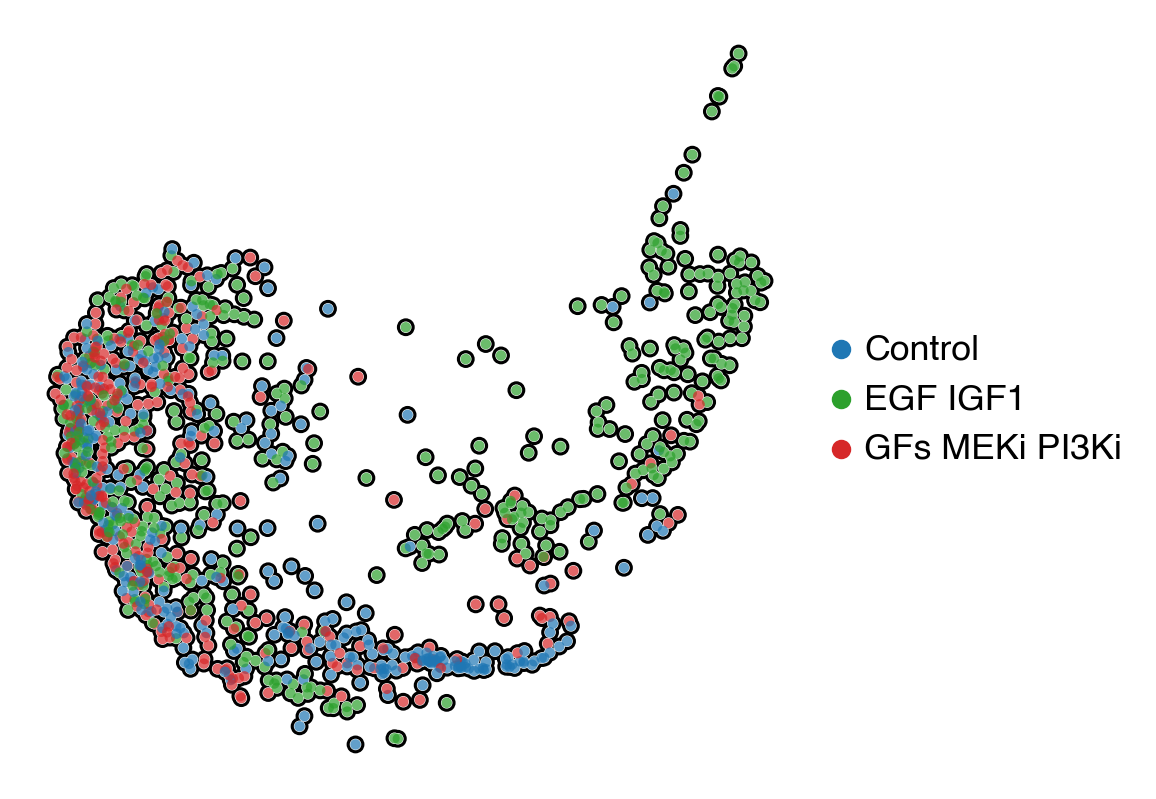

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provide

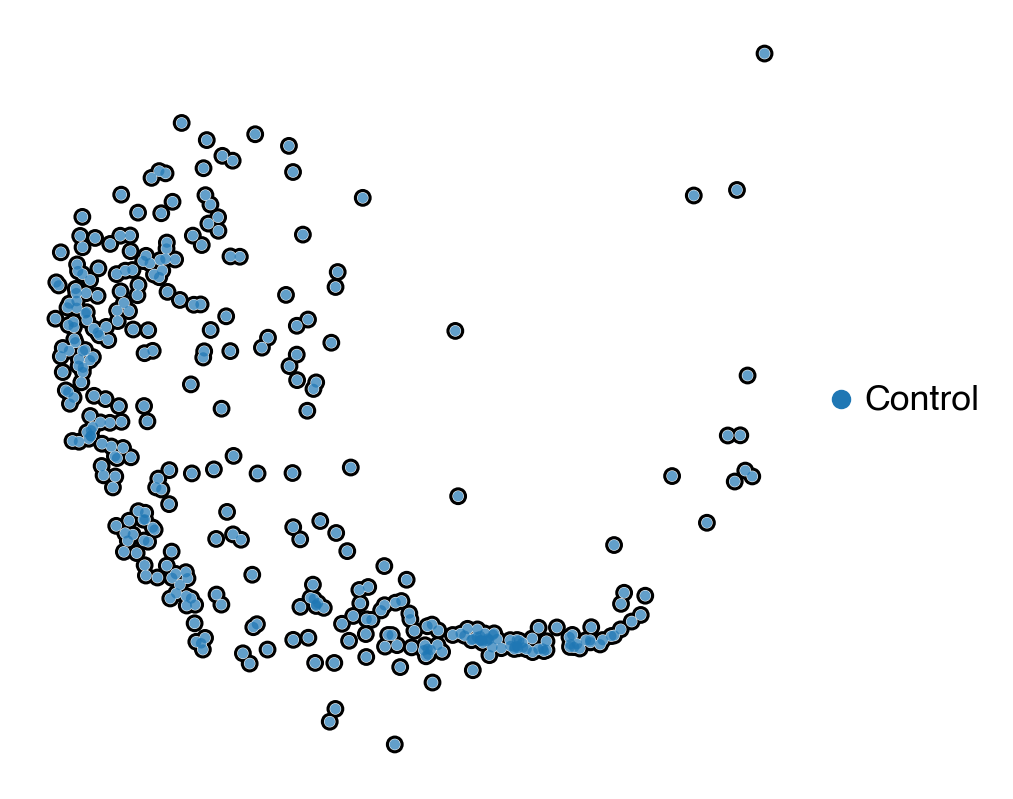

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provide

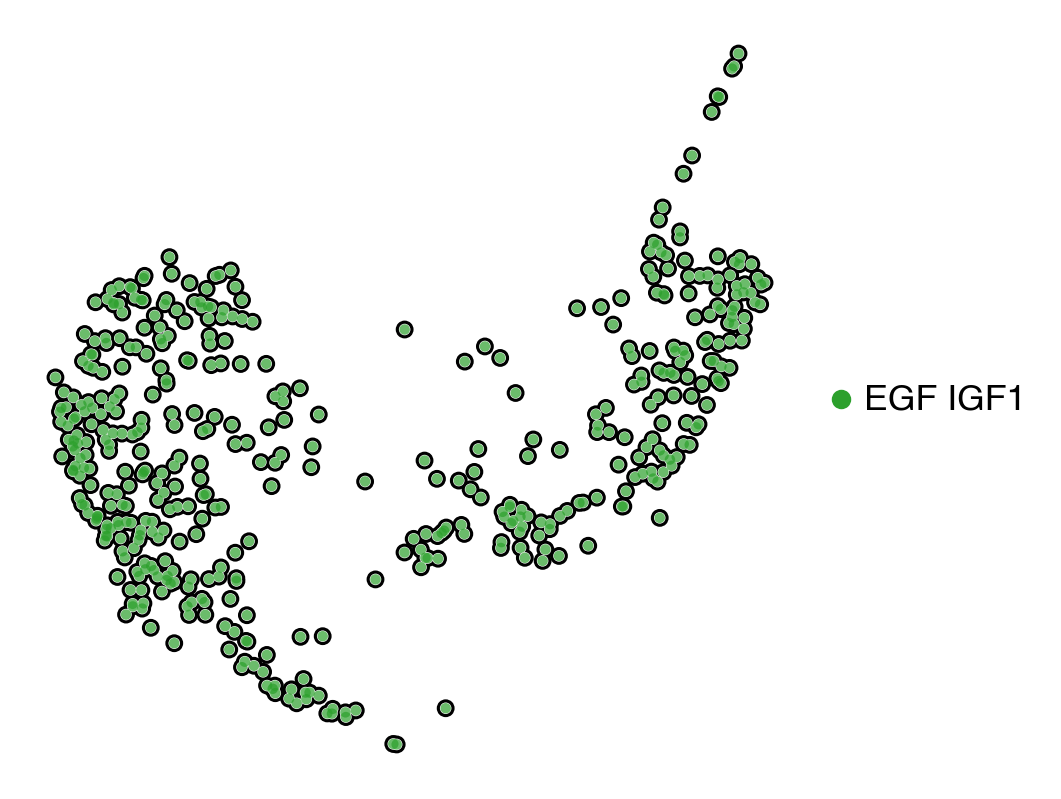

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provide

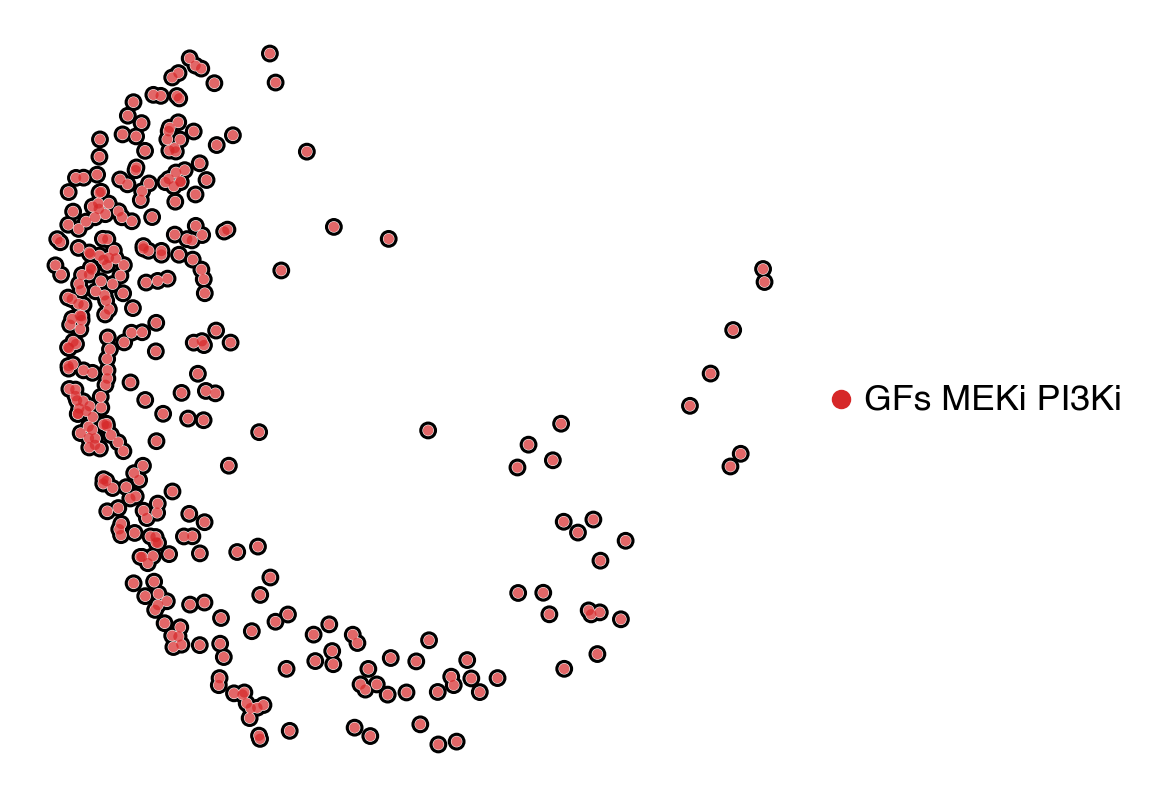

In [30]:
# View the ADT phates with sample_id colour
sc.pl.embedding(prot_adata_clr, basis='X_ptm_phate', color='sample_id', palette=colour_dict, 
frameon=False, add_outline=True, size = 57, title='', save="_adt_phate_all_conds")

# Subset only one sample_id
prot_adata_control = prot_adata_clr[prot_adata_clr.obs['sample_id'].isin(['Control'])]
sc.pl.embedding(prot_adata_control, basis='X_ptm_phate', color='sample_id', palette=colour_dict, 
frameon=False, add_outline=True, size = 57, title='', save="_adt_phate_control")

prot_adata_GF = prot_adata_clr[prot_adata_clr.obs['sample_id'].isin(['EGF IGF1'])]
sc.pl.embedding(prot_adata_GF, basis='X_ptm_phate', color='sample_id', palette=colour_dict, 
frameon=False, add_outline=True, size = 57, title='', save="_adt_phate_GFs")

prot_adata_GFI = prot_adata_clr[prot_adata_clr.obs['sample_id'].isin(['GFs MEKi PI3Ki'])]
sc.pl.embedding(prot_adata_GFI, basis='X_ptm_phate', color='sample_id', palette=colour_dict, 
frameon=False, add_outline=True, size = 57, title='', save="_adt_phate_ihibs")


In [31]:
# Swap the embeddings to do cross modality measurments
# Reassign object with ADT phate
adata_mrna_filtered.obsm['X_ptm_phate'] = Y

In [32]:
# Export as anndata in .h5ad across both modalities
adata_mrna_filtered.write_h5ad("ex0003_mrna_adata.h5ad")
prot_adata_clr.write_h5ad("ex0003_adt_adata.h5ad")

# Write as muon H5mu object for downstream analysis 
mdata.write("2023_03_30_mdata_01.h5mu")

In [33]:
# add the PTM measurements in obs of RNA object
adata_mrna_filtered.obs[ptm_markers] = ptm_marker_df

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


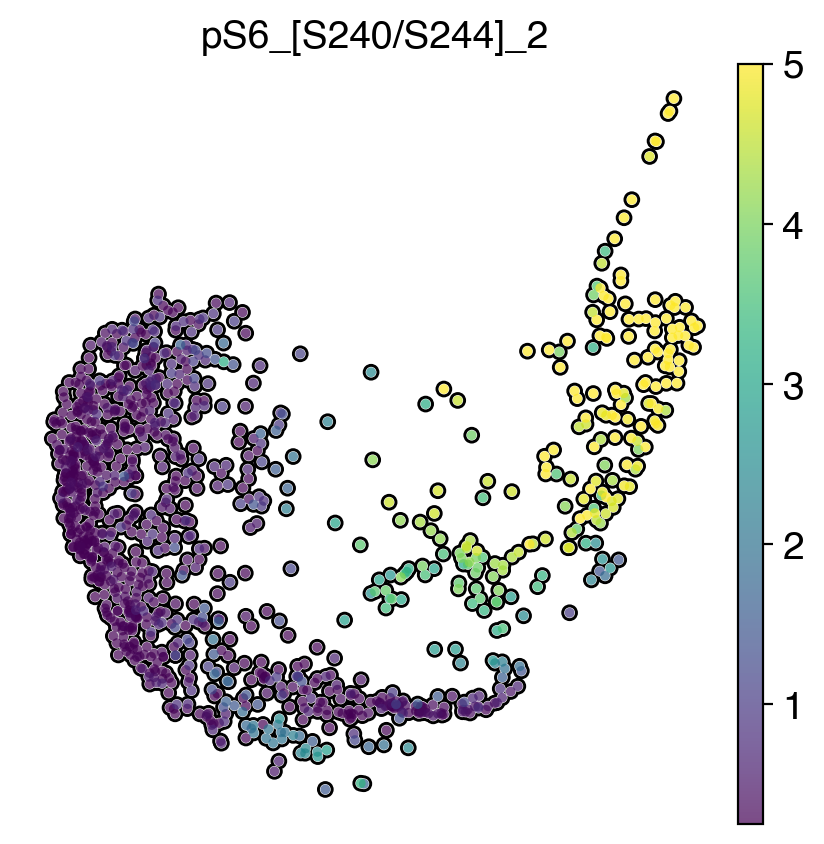

In [34]:
# Plot GEP activities
sc.pl.embedding(prot_adata_clr, basis='X_ptm_phate', color='pS6_[S240/S244]_2', add_outline=True,
           vmin=0.25, vmax=5, ncols = 4, frameon=False, size=50,
           save = 'adt_phate_pS6')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


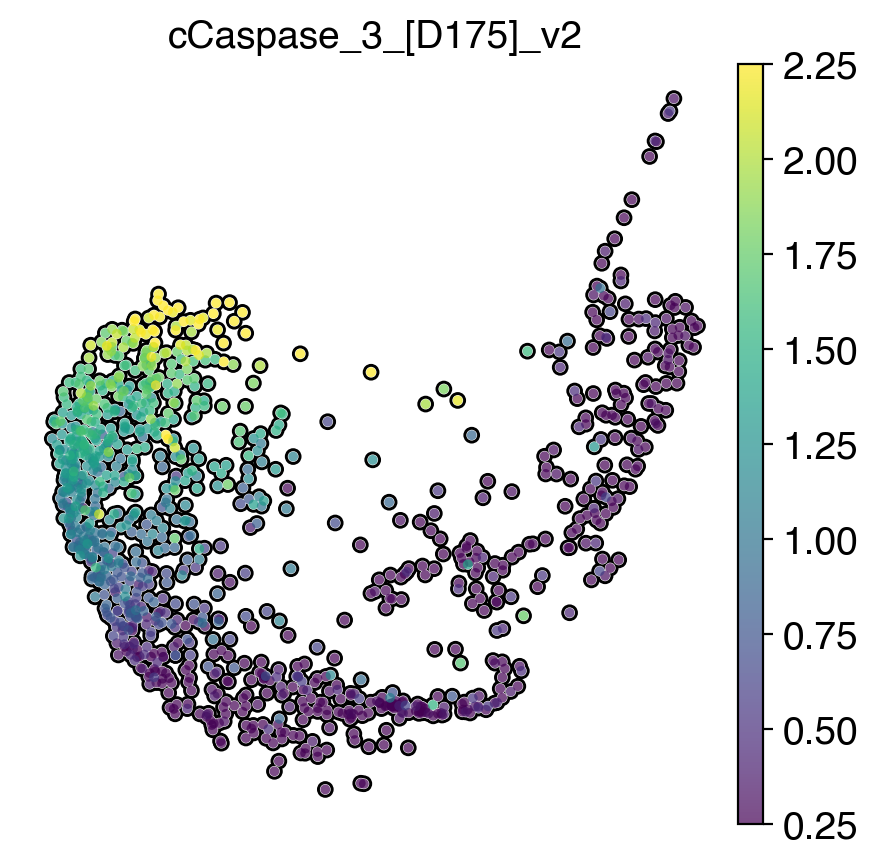

In [35]:
# Plot GEP activities
sc.pl.embedding(prot_adata_clr, basis='X_ptm_phate', color='cCaspase_3_[D175]_v2', add_outline=True,
           vmin=0.25, vmax=2.25, ncols = 4, frameon=False, size=50,
           save = 'adt_phate_cCasp3')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


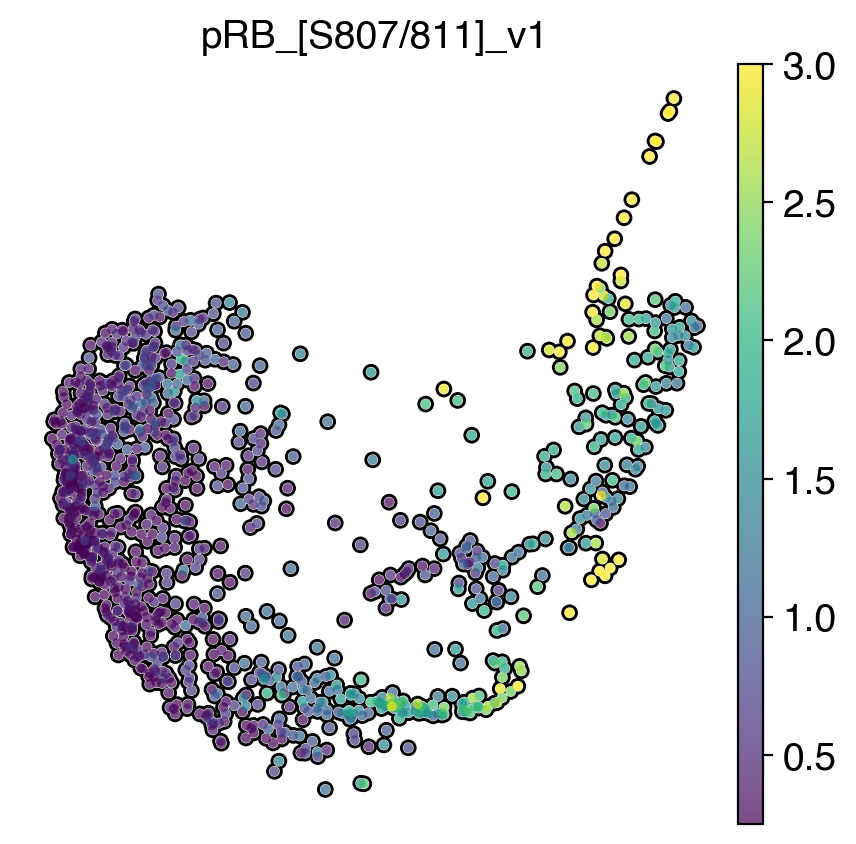

In [36]:
# Plot GEP activities
sc.pl.embedding(prot_adata_clr, basis='X_ptm_phate', color='pRB_[S807/811]_v1', add_outline=True,
           vmin=0.25, vmax=3, ncols = 4, frameon=False, size=50,
           save = 'adt_phate_pRb')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


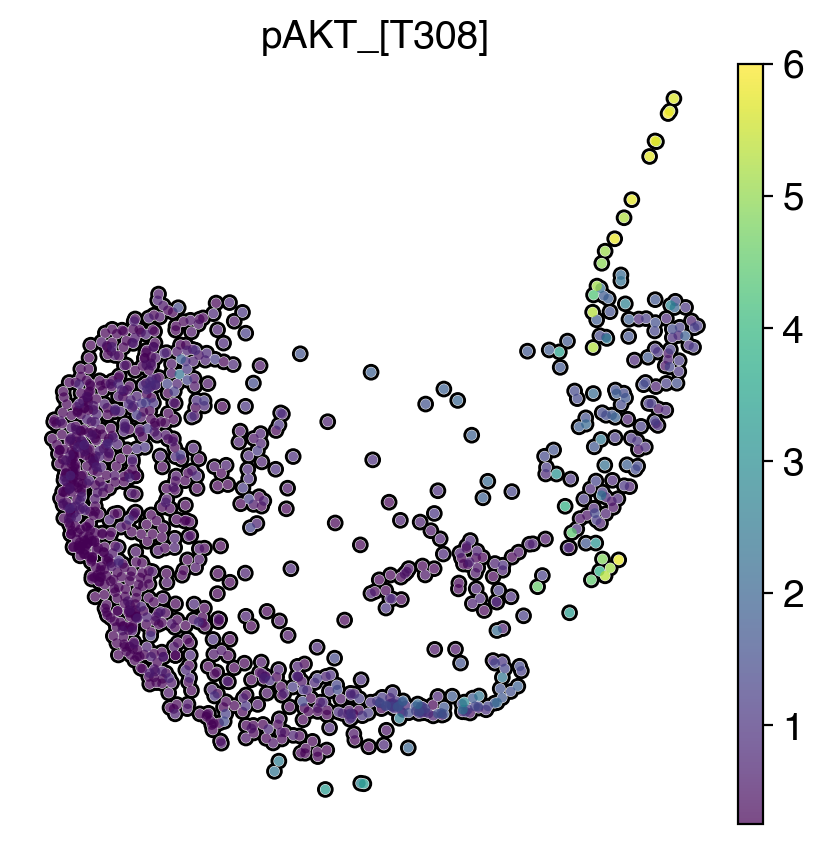

In [37]:
# Plot GEP activities
sc.pl.embedding(prot_adata_clr, basis='X_ptm_phate', color='pAKT_[T308]', add_outline=True,
           vmin=0.25, vmax=6, ncols = 4, frameon=False, size=50,
           save = 'adt_phate_pAkt')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


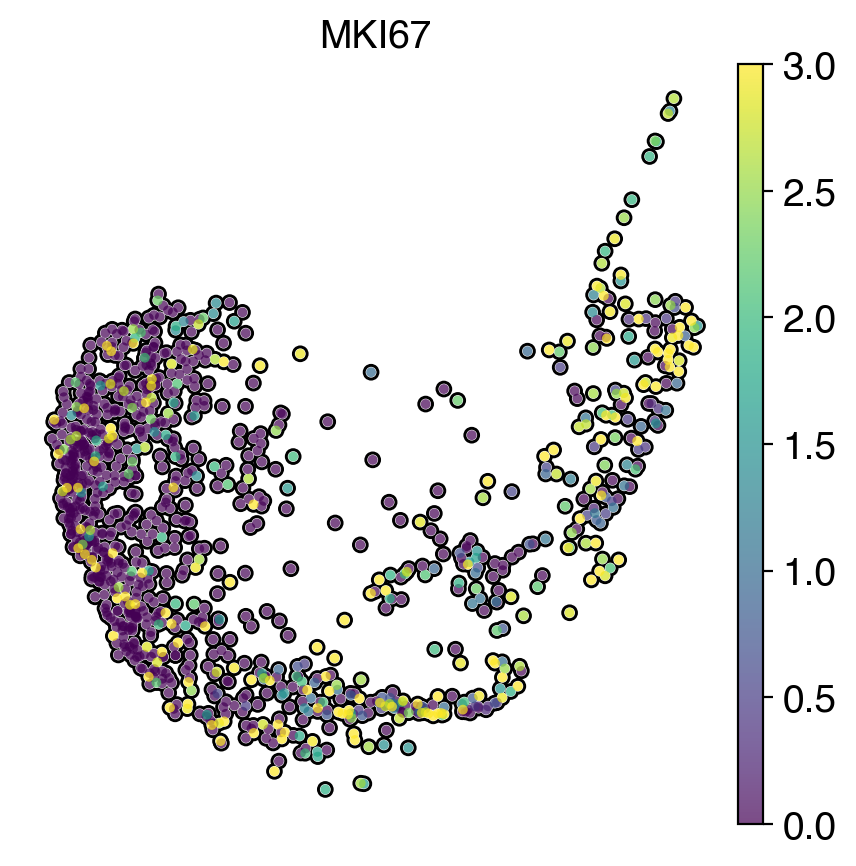

In [38]:
# Plot GEP activities
sc.pl.embedding(adata_mrna_filtered, basis='X_ptm_phate', color='MKI67', add_outline=True,
           frameon=False, size=50, use_raw=True, vmin=0, vmax=3,
           save = 'adt_phate_mki67')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


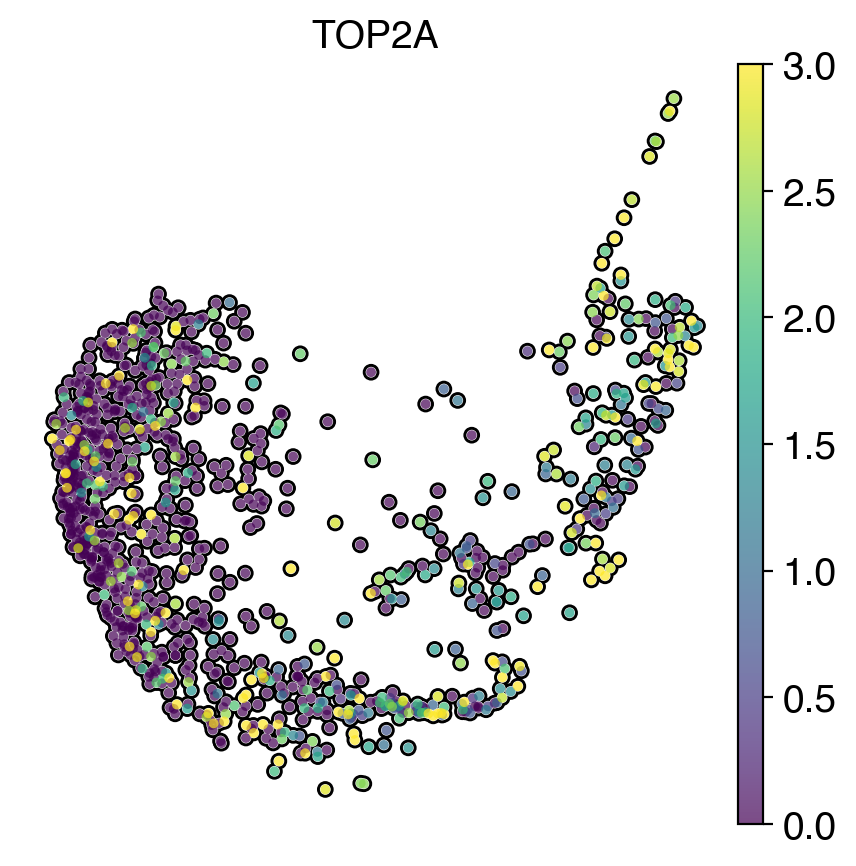

In [39]:
# Plot GEP activities
sc.pl.embedding(adata_mrna_filtered, basis='X_ptm_phate', color='TOP2A', add_outline=True,
           frameon=False, size=50, vmin=0, vmax=3,
           save = 'adt_phate_top2a')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


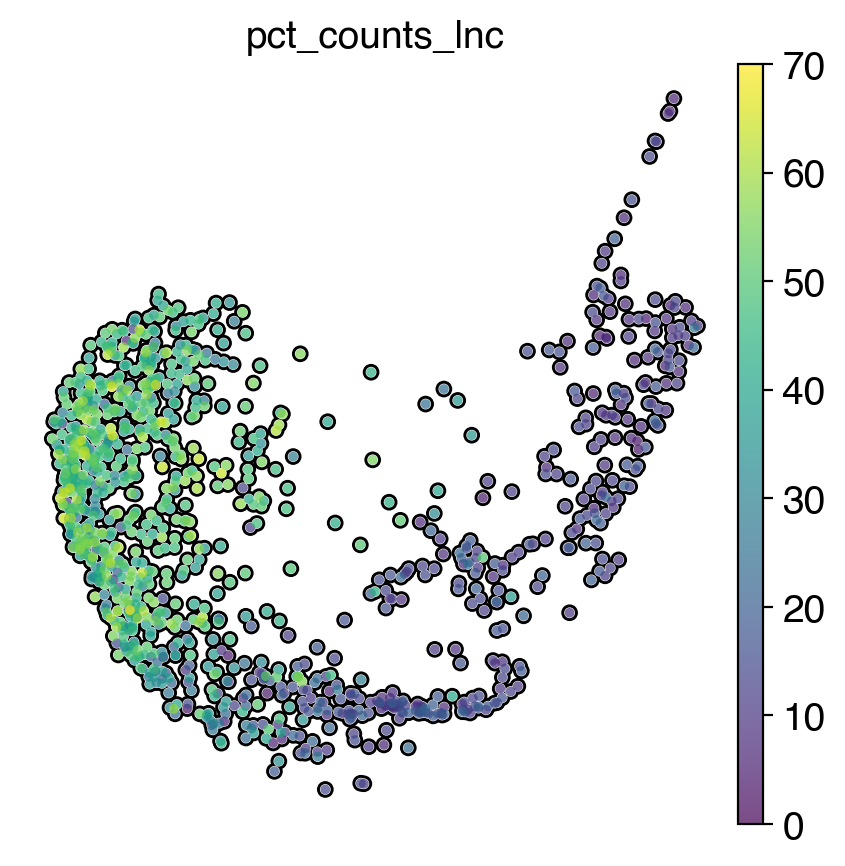

In [40]:
# Map onto object
sc.pl.embedding(adata_mrna_filtered, basis='X_ptm_phate', color='pct_counts_lnc', add_outline=True,
           vmin=0, vmax=70, ncols = 4, frameon=False, size=50,
           save = 'adt_phate_rna-lnc_annotation')

In [41]:
# Generate Rb and pS6 correlation
# Extract RNAdata
marker_genes = adata_mrna_filtered.var_names
ln_rna_data  = adata_mrna_filtered.raw.to_adata()
ln_rna_data.obs = adata_mrna_filtered.obs

# Get function
ln_mrna_data = sc.get.obs_df(
    ln_rna_data,
    keys=[*marker_genes]
)

In [42]:
# Extract the marker data from the adata object
mrna_data_obs = sc.get.obs_df(
    ln_rna_data,
    keys=['well_indexes', 'Amit_Nat_Gen_2007', 'sample_id', 'phase','n_genes_by_counts' , 'total_counts', *marker_genes]
)

mrna_data_obs.to_csv('ex0003_mrna_obsm_data.csv')

In [43]:
# Calculate correlation for each column
correlation_results = ln_mrna_data.apply(lambda col: col.corr(pd.Series(adata_mrna_filtered.obs['pS6_[S240/S244]_2'])))

# Sort the correlation results in descending order
correlation_results_sorted = correlation_results.sort_values(ascending=False)

In [44]:
# Extract gene_names
ps6_df = pd.DataFrame(correlation_results_sorted).reset_index()
ps6_df.to_csv('ps6_corr.csv')

In [45]:
# List of strings to match
amit_genes = amit_gene_df['gene_symbol_20_40min'].to_list()

# extract the amit gene list
ps6_amit_df = ps6_df[ps6_df['index'].isin(amit_genes)]

In [46]:
# generate rank from index
rank_corr_df = ps6_df.reset_index()
rank_corr_df = rank_corr_df.rename(columns={"level_0": "rank", "index": "gene", 0:"corr"})

rank_genes = ps6_amit_df['index'][:10]

# Creating a new column 'genes' with True/False values
rank_corr_df['amit_genes'] = rank_corr_df['gene'].apply(lambda x: any(gene == x for gene in rank_genes))

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


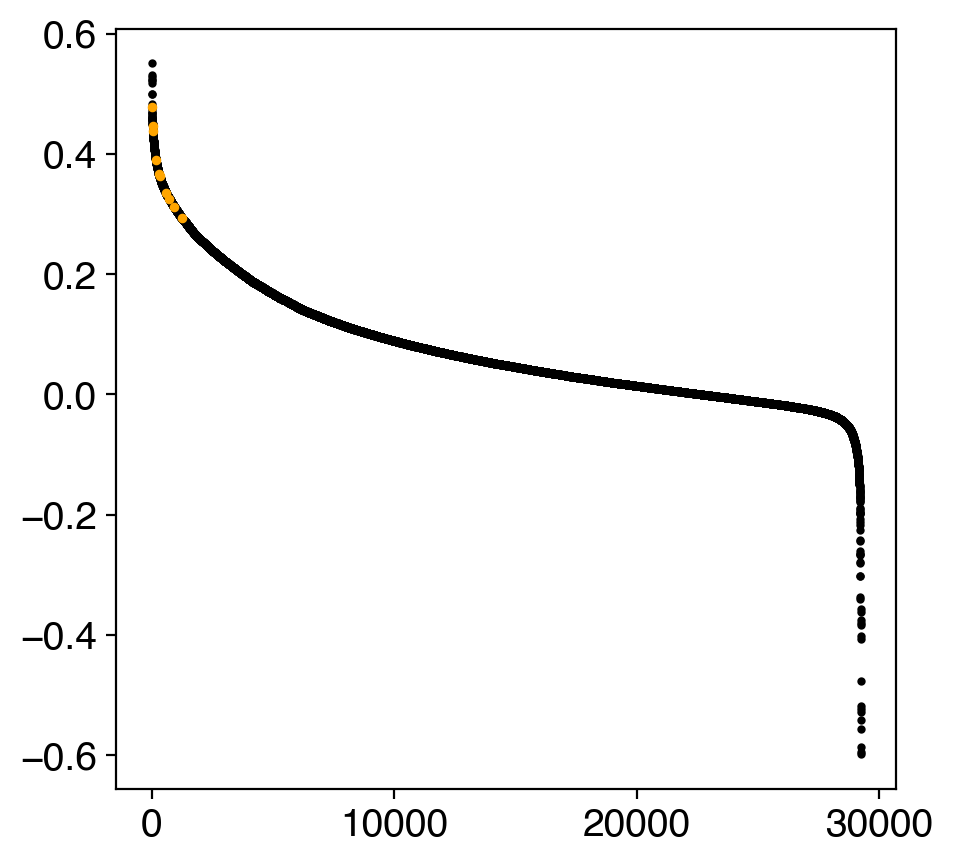

In [47]:
fig, axs = plt.subplots(1, 1)

plot_mask = rank_corr_df['amit_genes'] == True

axs.scatter(rank_corr_df.loc[~plot_mask, 'rank'], rank_corr_df.loc[~plot_mask, 'corr'], c='black', label='gene', s=4)
axs.scatter(rank_corr_df.loc[plot_mask, 'rank'], rank_corr_df.loc[plot_mask, 'corr'], c='orange', label='EGF Respnse gene', s=6)
axs.legend([], [], frameon=False)

# Turns off grid on the left Axis.
axs.grid(False)

plt.savefig("egf_response_barcode_rankplot.pdf")

In [48]:
rank_corr_df['amit_genes'] == True

0        False
1        False
2        False
3        False
4        False
         ...  
29232    False
29233    False
29234    False
29235    False
29236    False
Name: amit_genes, Length: 29237, dtype: bool

In [49]:
rank_corr_df.loc[plot_mask]

,rank,gene,corr,amit_genes
10,10,EGR1,0.477294,True
35,35,TIPARP,0.446717,True
46,46,FOS,0.437537,True
173,173,NR4A3,0.389150,True
286,286,NFIB,0.366781,True
321,321,MBNL1,0.362470,True
589,589,KLF6,0.334777,True
718,718,KLF10,0.325571,True
933,933,JUNB,0.311520,True
1243,1243,PIAS1,0.293069,True


/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_53204/2029227459.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = mpl.cm.get_cmap('PiYG')
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


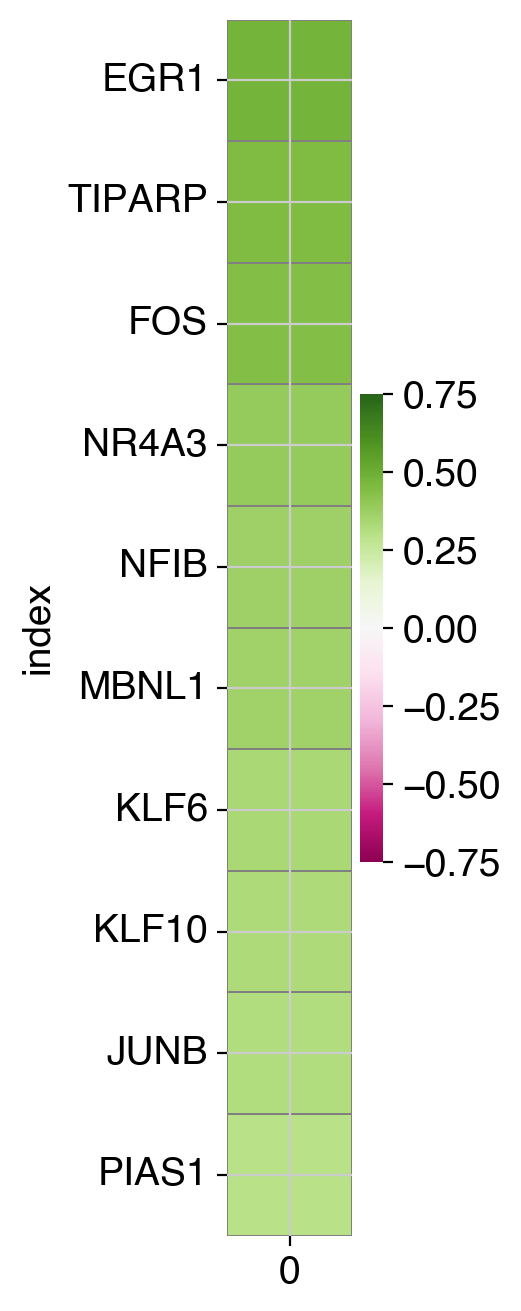

In [50]:
# Plot ordered correlation heatmap
hm_df = ps6_amit_df.set_index("index").head(n=10)

fig, ax = plt.subplots(figsize=(1, 8))
colormap = mpl.cm.get_cmap('PiYG')
offset = mcolors.TwoSlopeNorm(vcenter=-0, vmin = -0.75, vmax = 0.75)
sns.heatmap(hm_df, cmap=colormap,norm=offset, linewidths = 0.05, linecolor='grey')
plt.savefig('cell_state.pdf', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

In [51]:
sc.pp.scale(adata_mrna_filtered, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


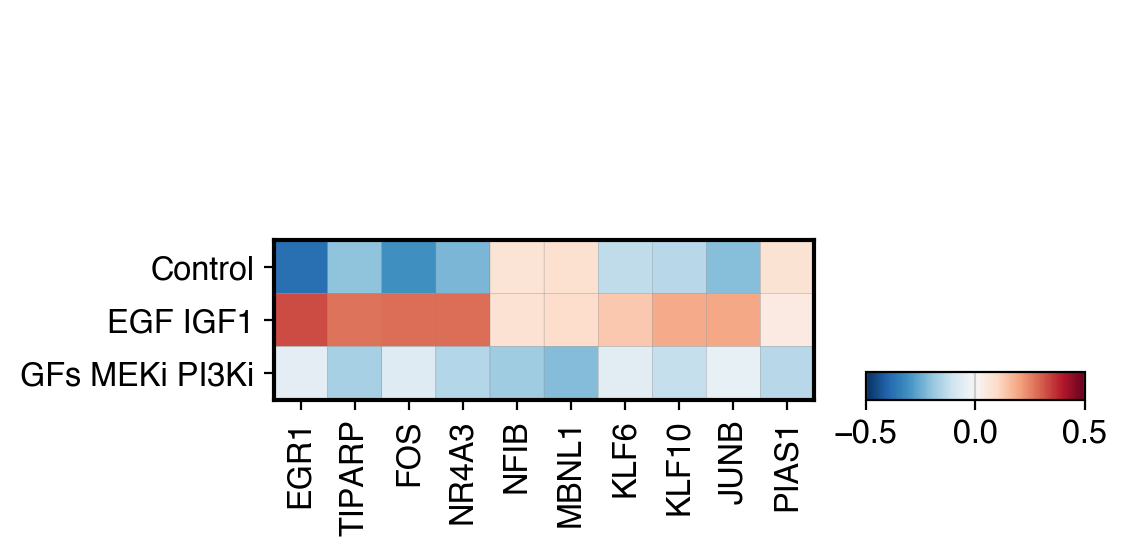

In [52]:
amit_genes_hm = ps6_amit_df['index'].to_list()[:10]
sc.pl.matrixplot(adata_mrna_filtered, amit_genes_hm, groupby='sample_id', dendrogram=False, use_raw=False,
                 categories_order=['Control', 'EGF IGF1', 'GFs MEKi PI3Ki'],
                 colorbar_title='', vmin=-0.5, vmax=0.5, cmap= 'RdBu_r', save='col_zscaled_amit_EGF_response.pdf')